In [1]:
import numpy as np
import pandas as pd
import os
import time
import pickle
import gzip

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
%matplotlib inline

from sklearn.metrics import accuracy_score, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Fashion MNIST dataset
- 28*28 pixels(784 차원)
- label
  - 0 T-shirt/top
  - 1 Trouser
  - 2 Pullover
  - 3 Dress
  - 4 Coat
  - 5 Sandal
  - 6 Shirt
  - 7 Sneaker
  - 8 Bag
  - 9 Ankle boot


In [11]:
#데이터 불러오기
#fashion=pd.read_csv('/content/drive/MyDrive/DSL 2023-1/차원축소 세션 준비/fashion-mnist.csv') #경로수정
fashion=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/7주차/[0207]_Dimensionality Reduction_실습, 과제/fashion-mnist.csv')
fashion.head(3) #60000 rows

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0


- (Q1) X_train, y_train, X_test, y_test 지정하기
  - 60000개의 전체 데이터셋 사용하지 않아도 됨 (학습 속도가 느려짐)
  - 본인이 생각하는 적절한 train 개수, test 개수를 설정하여 분리하도록
    - 이때 train과 test 데이터의 라벨 분포가 균등하게 이루어지도록 분리해야함(학습시에 편향되지 않도록)
    - 그래프 그려서 라벨값 분포가 균등한지 확인할 것

In [15]:
y_label = fashion.loc[:, 'label']
X_features = fashion.drop(['label'],axis=1)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


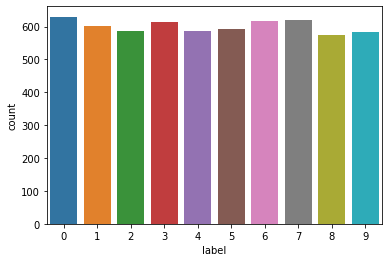

In [59]:
X_train=X_features.loc[:5999,:]
y_train=y_label[:6000]
sns.countplot(y_train)
plt.show()

# train data로 6000개 사용
# 균일한 정도로 분포한다고 판단 가능

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


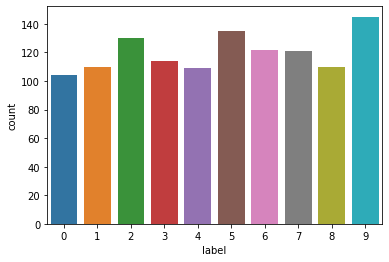

In [104]:
X_test=X_features.loc[6000:7199,:]
y_test=y_label[6000:7200]
sns.countplot(y_test)
plt.show()

# test data로 1200개 사용
# train에 비해서는 균일하지 않지만, 전체적으로 크게 불균일하지 않다고 판단

In [108]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(6000, 784) (6000,) (1200, 784) (1200,)


- 어떻게 생긴 데이터셋인지 확인해보기

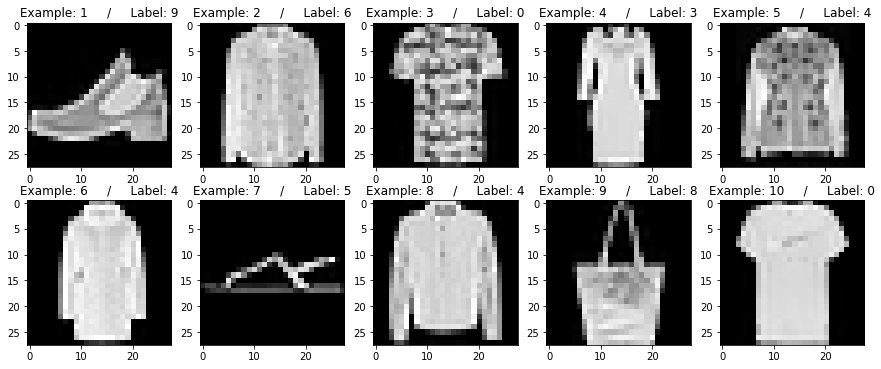

In [34]:
plt.figure(figsize=(15,6))
for i in range(1,11):
  plt.subplot(2,5,i)
  label = y_train.loc[i]
  image = X_train.loc[i,:].values.reshape([28, 28])
  plt.imshow(image, cmap=plt.get_cmap('gray'))
  plt.title('Example: %d     /     Label: %d'%(i, label))

plt.show()

# PCA를 활용해 성능 높여보기


- (Q2) 합리적인 잠재변수 개수 설정하기
  - PCA에서 각 잠재변수가 설명하는 분산 비율을 보고 적절한 잠재변수 개수 설정
  - 개수 설정 기준은 본인 재량. 다만, 명확한 기준을 서술할 것.

In [109]:
from sklearn.decomposition import PCA
pca=PCA(n_components=784)
X_train_PCA=pca.fit_transform(X_train)
X_train_PCA.shape

(6000, 784)

In [110]:
pca.explained_variance_ratio_[:25]

# 숫자가 급격하게 바뀌다가 완만해지는 부분이 18개 이후로 판단

array([0.29050597, 0.17572419, 0.06026001, 0.05078458, 0.03887818,
       0.03575782, 0.02255403, 0.01916186, 0.01380836, 0.01286293,
       0.00967577, 0.00927129, 0.00791519, 0.00655081, 0.00612488,
       0.00600107, 0.00564911, 0.00523896, 0.00458285, 0.00453794,
       0.00428275, 0.00405387, 0.0038901 , 0.00369262, 0.00363646])

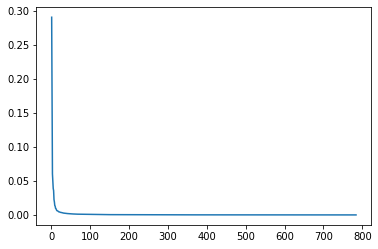

In [111]:
plt.plot(range(1,785),pca.explained_variance_ratio_)
plt.show()

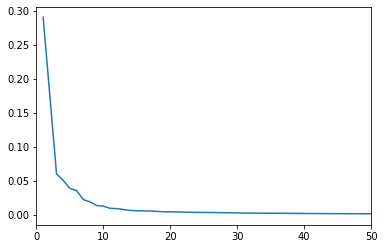

In [112]:
plt.plot(range(1,785),pca.explained_variance_ratio_)
plt.xlim(0,50)
plt.show()

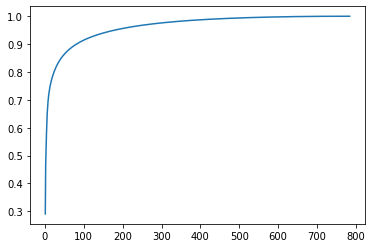

In [113]:
cumulative = []
temp = 0
for i in range(0, 784):
    temp += pca.explained_variance_ratio_[i]
    cumulative.append(temp)

plt.plot(range(1,785),cumulative)
plt.show()

In [114]:
for i in [10,20,50,100,784]:
  explained=np.sum(pca.explained_variance_ratio_[:i])
  print('The variance explained by the ', i, 'latent variables is {:.2f}%'.format(explained*100))

The variance explained by the  10 latent variables is 72.03%
The variance explained by the  20 latent variables is 78.58%
The variance explained by the  50 latent variables is 86.39%
The variance explained by the  100 latent variables is 91.43%
The variance explained by the  784 latent variables is 100.00%


In [115]:
cumulative=np.array(cumulative)
print(np.where(cumulative>0.75)[0][0], np.where(cumulative>0.8)[0][0], sep='\n')
# 13개에서 23개 사이에서 전체 데이터의 75%~80%를 설명하는 분산이 존재

13
23


숫자의 급격한 변화가 완만해지는 시점을 18개의 잠재변수 이루로 판단, 13개 ~ 23개 사이에서 전체 데이터의 75% ~ 80%를 설명하는 분산이 존재
-> 18개를 사용하기로 결정, 77% 정도를 설명할 것으로 보임

- (Q3) 학습속도, 성능의 향상을 보이는지 확인
  - 기존에 배웠던 여러가지 classification model들 활용하기
  - 최소한 1가지 이상의 모델에 대해 비교해보고 차원축소 이전, 이후 어떠한 차이를 보이는지 서술


In [117]:
pca=PCA(n_components=18)
X_train_PCA=pca.fit_transform(X_train)
X_test_PCA=pca.transform(X_test)
print('Original space:',X_train.shape)
print('After PCA:',X_train_PCA.shape)

Original space: (6000, 784)
After PCA: (6000, 18)


##### Logistic regression

In [96]:
start=time.time()
logistic_original=LogisticRegression(max_iter=1000)
logistic_original.fit(X_train,y_train)
print('train accuracy:',accuracy_score(y_train, logistic_original.predict(X_train)))
print('test accuracy:',accuracy_score(y_test, logistic_original.predict(X_test)))
print(f'{time.time()-start:.4f}sec')

train accuracy: 1.0
test accuracy: 0.7641666666666667
52.8925sec


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [118]:
start=time.time()
logistic_pca=LogisticRegression(max_iter=1000) 
logistic_pca.fit(X_train_PCA,y_train)
print('train accuracy:',accuracy_score(y_train, logistic_pca.predict(X_train_PCA)))
print('test accuracy:',accuracy_score(y_test, logistic_pca.predict(X_test_PCA)))
print(f'{time.time()-start:.4f}sec')

train accuracy: 0.8126666666666666
test accuracy: 0.7975
9.0326sec


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


- PCA를 진행한 후에 학습 속도가 빨라지는 것이 확인되었다.
- PCA 이전보다 이후에 train accuracy는 조금 낮아졌다. 그러나 test accuracy가 높아지는 것이 확인되었다. 고차원 공간에서 data가 overfitting 되었던 경향이 있었던 것으로 판단된다.
- 차원을 축소하여 학습을 시키는 것이 훨씬 효과적이었던 것으로 판단할 수 있다.

##### Random Forest

In [119]:
start=time.time()
rf_original=RandomForestClassifier()
rf_original.fit(X_train,y_train)
print('train accuracy:',accuracy_score(y_train, rf_original.predict(X_train)))
print('test accuracy:',accuracy_score(y_test, rf_original.predict(X_test)))
print(f'{time.time()-start:.4f}sec')

train accuracy: 1.0
test accuracy: 0.8375
9.3868sec


In [120]:
start=time.time()
rf_pca=RandomForestClassifier()
rf_pca.fit(X_train_PCA, y_train)
print('train accuracy:',accuracy_score(y_train, rf_pca.predict(X_train_PCA)))
print('test accuracy:',accuracy_score(y_test, rf_pca.predict(X_test_PCA)))
print(f'{time.time()-start:.4f}sec')

train accuracy: 1.0
test accuracy: 0.8258333333333333
4.3778sec


- PCA 이전과 이후에 train accuracy에는 차이가 없고, test accuracy는 이후에서 매우 미세하게 낮아졌지만 큰 차이가 없는 것으로 판단할 수 있다.
- 학습에 걸리는 시간이 두 배 이상 빨라진 것으로 보아, 차원 축소가 효과적이라고 볼 수 있다.
- Logistic regression에 비해서, 이전과 이후 모두 정확도가 전체적으로 높게 나타나고 시간이 훨씬 적게 걸린다.

##### XGBoost

In [121]:
from xgboost import XGBClassifier
start=time.time()
xgboost_original = XGBClassifier()
xgboost_original.fit(X_train, y_train)
print('train accuracy:',accuracy_score(y_train, xgboost_original.predict(X_train)))
print('test accuracy:',accuracy_score(y_test, xgboost_original.predict(X_test)))
print(f'{time.time()-start:.4f}sec')

train accuracy: 0.9485
test accuracy: 0.835
146.7199sec


In [122]:
start=time.time()
xgboost_pca = XGBClassifier()
xgboost_pca.fit(X_train_PCA, y_train)
print('train accuracy:',accuracy_score(y_train, xgboost_pca.predict(X_train_PCA)))
print('test accuracy:',accuracy_score(y_test, xgboost_pca.predict(X_test_PCA)))
print(f'{time.time()-start:.4f}sec')

train accuracy: 0.8828333333333334
test accuracy: 0.7958333333333333
9.8866sec


- PCA 이전에 비해서 이후에 걸리는 시간이 매우 짧아진다는 점에서 효과적이다.
- PCA 이전과 비교해서 정확도는 train과 test 모두 조금 감소하는 경향이 있다.
- 그러나 비슷한 성능에서 걸리는 시간이 매우 빨라지므로 차원축소가 효과적이라고 볼 수 있다.

# 2차원으로 시각화
- (Q4) 여러가지 차원 축소 방법 중 적절할 것으로 예상되는 방법 최소한 3가지 이용해서 시각화해보기
  - 하나의 차원 축소 방법도 하이퍼파라미터의 설정 다양하게 해보기
  - ex) KPCA에서 다양한 커널 함수 사용, ISOMAP or LLE에서 고려할 이웃의 개수 변경해보기

In [123]:
start=time.time()
pca=PCA(n_components=2)
X_train_PCA=pca.fit_transform(X_train) 
print(f'{time.time()-start:.4f}sec')

0.7354sec


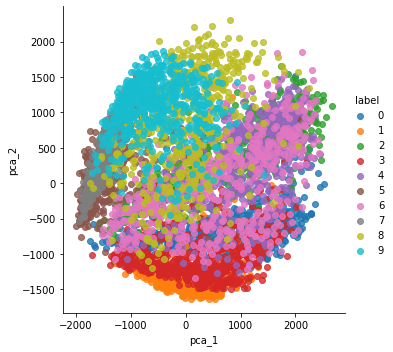

In [124]:
X_train_pca=pd.DataFrame(X_train_PCA).loc[:,0:1]
X_train_pca=pd.concat((X_train_pca, y_train), axis=1) 
X_train_pca.columns=['pca_1', 'pca_2', 'label']

sns.lmplot(x='pca_1',y='pca_2',data=X_train_pca,hue='label',fit_reg=False)
plt.show()

##### MDS

In [125]:
from sklearn.manifold import MDS
start=time.time()
mds = MDS(n_components=2, random_state=42)
X_train_mds = mds.fit_transform(X_train)
print(f'{time.time()-start:.4f}sec')

1583.5205sec


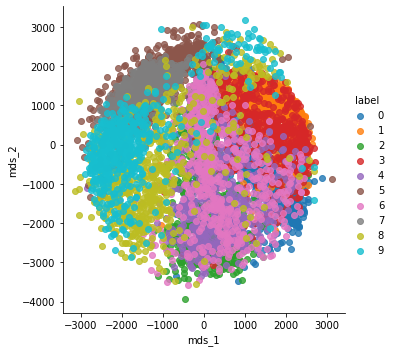

In [126]:
X_train_mds=pd.DataFrame(X_train_mds).loc[:,0:1]
X_train_mds=pd.concat((X_train_mds, y_train), axis=1) 
X_train_mds.columns=['mds_1', 'mds_2', 'label']
X_train_mds

sns.lmplot(x='mds_1',y='mds_2',data=X_train_mds,hue='label',fit_reg=False)
plt.show()

##### LDA

In [127]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
start=time.time()
lda = LinearDiscriminantAnalysis(n_components=2)
X_train_lda = lda.fit_transform(X_train, y_train)
print(f'{time.time()-start:.4f}sec')

3.4646sec


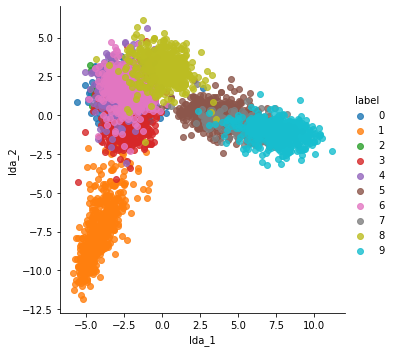

In [128]:
X_train_lda=pd.DataFrame(X_train_lda).loc[:,0:1]
X_train_lda=pd.concat((X_train_lda, y_train), axis=1) 
X_train_lda.columns=['lda_1', 'lda_2', 'label']
X_train_lda

sns.lmplot(x='lda_1',y='lda_2',data=X_train_lda,hue='label',fit_reg=False)
plt.show()

##### KPCA

In [139]:
from sklearn.decomposition import KernelPCA
start=time.time()
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True) #방사형 커널 사용
X_train_rbf_pca=rbf_pca.fit_transform(X_train)
print(f'{time.time()-start:.4f}sec')

24.8202sec


In [140]:
start=time.time()
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True) #시그모이드 커널 사용
X_train_sig_pca=sig_pca.fit_transform(X_train)
#X_test_rbf_pca=sig_pca.fit_transform(X_test)
print(f'{time.time()-start:.4f}sec')

22.0732sec


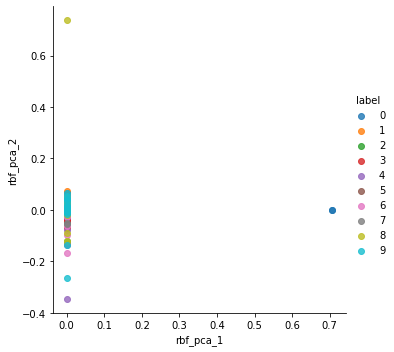

In [141]:
X_train_rbf_pca=pd.DataFrame(X_train_rbf_pca).loc[:,0:1]
X_train_rbf_pca=pd.concat((X_train_rbf_pca, y_train), axis=1) 
X_train_rbf_pca.columns=['rbf_pca_1', 'rbf_pca_2', 'label']

sns.lmplot(x='rbf_pca_1',y='rbf_pca_2',data=X_train_rbf_pca,hue='label',fit_reg=False)
plt.show()

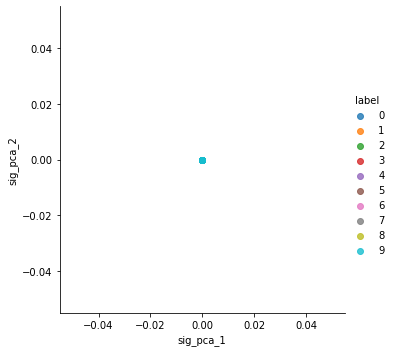

In [142]:
X_train_sig_pca=pd.DataFrame(X_train_sig_pca).loc[:,0:1]
X_train_sig_pca=pd.concat((X_train_sig_pca, y_train), axis=1) 
X_train_sig_pca.columns=['sig_pca_1', 'sig_pca_2', 'label']

sns.lmplot(x='sig_pca_1',y='sig_pca_2',data=X_train_sig_pca,hue='label',fit_reg=False)
plt.show()

##### ISOMAP

In [133]:
from sklearn.manifold import Isomap
start=time.time()
isomap=Isomap(n_neighbors=5,n_components=2,n_jobs=4)         
X_train_isomap=isomap.fit_transform(X_train)
print(f'{time.time()-start:.4f}sec')

37.5516sec


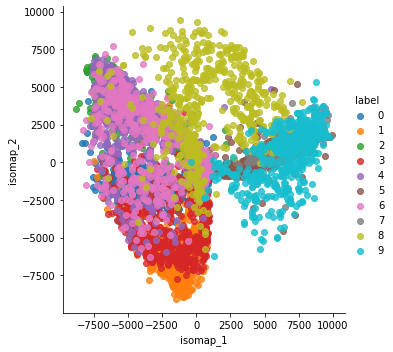

In [134]:
X_train_isomap=pd.DataFrame(X_train_isomap).loc[:,0:1]
X_train_isomap=pd.concat((X_train_isomap, y_train), axis=1) 
X_train_isomap.columns=['isomap_1', 'isomap_2', 'label']

sns.lmplot(x='isomap_1',y='isomap_2',data=X_train_isomap,hue='label',fit_reg=False)
plt.show()

##### LLE

In [135]:
from sklearn.manifold import LocallyLinearEmbedding
start=time.time()
lle = LocallyLinearEmbedding(n_components=2, random_state=42)
X_train_lle = lle.fit_transform(X_train)
#X_test_lle=lle.transform(X_test)
print(f'{time.time()-start:.4f}sec')

4.7459sec


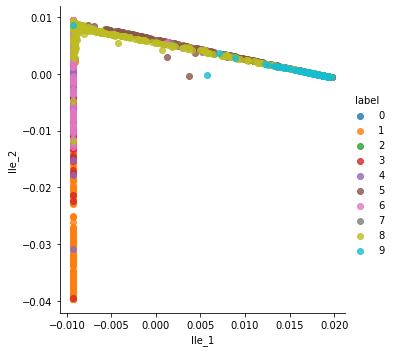

In [136]:
X_train_lle=pd.DataFrame(X_train_lle).loc[:,0:1]
X_train_lle=pd.concat((X_train_lle, y_train), axis=1) 
X_train_lle.columns=['lle_1', 'lle_2', 'label']
X_train_lle

sns.lmplot(x='lle_1',y='lle_2',data=X_train_lle,hue='label',fit_reg=False)
plt.show()

##### t-SNE

In [137]:
from sklearn.manifold import TSNE
start=time.time()
tsne = TSNE(n_components=2, random_state=18)
X_train_tsne = tsne.fit_transform(X_train)
print(f'{time.time()-start:.4f}sec')

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


63.2859sec


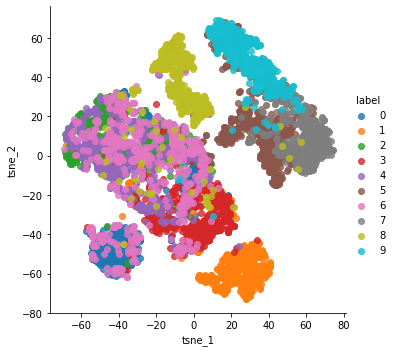

In [138]:
X_train_tsne=pd.DataFrame(X_train_tsne).loc[:,0:1]
X_train_tsne=pd.concat((X_train_tsne, y_train), axis=1) 
X_train_tsne.columns=['tsne_1', 'tsne_2', 'label']
X_train_tsne

sns.lmplot(x='tsne_1',y='tsne_2',data=X_train_tsne,hue='label',fit_reg=False)
plt.show()

- (Q5) 시도해본 차원축소 방법 중 Fashion MNIST 데이터셋을 가장 잘 시각화하는 것으로 보이는 방법은 무엇인지 서술해보자.

t-SNE를 이용하여 시각화하는 것이 가장 데이터셋을 잘 시각화하는 것으로 보인다.
umap을 함께 이용하여 시각화하면 더 좋은 결과가 나타날 것이라고 생각한다. LDA의 경우에도 마찬가지로 차원 축에 따라서 데이터가 잘 나누어진 모습으로 보여서 시각화가 잘 이루어진 것 같다. KPCA의 경우에는 시각화가 가장 잘 이루어지지 않았다.

- (Q6) 저차원에서 제대로 분류가 잘 되지 않는 라벨은 무엇인지 언급해보고, 왜 제대로 분류되지 않을 것인지 추측해보자.

t-SNE를 기준으로 보았을 때, label 8의 일부가 잘 분류되지 않고 퍼져있는 모습을 볼 수 있었다.
label 8의 이미지가 다른 label과 유사한 부분이 있는 것으로 보인다.
label 0이 두 개의 cluster로 나뉜 것으로 보아, 다른 label들과 유사한 두 가지 특징이 있는 것으로 보인다.
전체적으로 보았을 때, label 1,2,3,5,7,9는 잘 분류된 것으로 보인다.
LDA의 경우에는 같은 label끼리 잘 모여있는 모습으로 보인다.


수고하셨습니다~